# Задача 6. Компьютерное зрение: задача сегментации
Обучаем Сегментацию:

* https://colab.research.google.com/drive/1eUIOnLFB_9_6CJ3dVZxY9TV_gCqDAmaV?authuser=1#scrollTo=SjKfL5X_RbzH --- тут мы обучали на большом датасете одну эпоху.
* https://drive.google.com/file/d/11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe/view?usp=sharing --- тут лежит датасет который мы будем использовать.

* Сделать train/test split (или кросс-валидацию), зафиксировать все сиды чтобы более-менее воспроизводились результаты. Добавить метрику **jaccard index**. Переобучиться на одном батче (например 4 картинки), попробовать получить почти идеальное качество, посмотреть получилось или нет. Посчитать метрики для батча и для теста. Обучить на всем train, построить train/val кривые для loss и для **jaccard index**, подобрать оптимальное время обучения (количество шагов) для фиксированных параметров. Визуализировать topN самых плохих предсказаний.
* Попробовать улучшить качество не меняя архитектуру: аугментации, гиперпараметры. Сделать test time аугментации через horizontal flip, посмотреть улучшается ли что-то.
* Попробовать улучшить качество изменяя архитектуру.

Автор: Мотыка Артем Игоревич



In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import copy
import random
import cv2
from pathlib import Path
import pandas as pd
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from torch import nn
from torchvision import transforms
from torchvision.transforms import functional
from tqdm.auto import tqdm, trange

In [3]:
def reset_random_seeds():
    torch.manual_seed(2)
    random.seed(2)

# Реализация UNet

In [39]:
class ConvBlockDouble(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class Encoder(nn.Module):
    def __init__(self, in_channels, n_down):
        super().__init__()

        self.enc_layers = nn.ModuleList([ConvBlockDouble(in_channels, in_channels * 2)])

        for _ in range(n_down):
            in_channels *= 2
            self.enc_layers.append(nn.Sequential(nn.MaxPool2d(2, 2), ConvBlockDouble(in_channels, in_channels * 2)))

    def forward(self, x):
        results = []
        for layer in self.enc_layers:
            x = layer(x)
            results.append(x)
        return results

class Decoder(nn.Module):
    def __init__(self, in_channels, n_up):
        super().__init__()

        self.dec_layers = nn.ModuleList()
        for _ in range(n_up):
            out_channels = in_channels // 2
            self.dec_layers += [
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                ConvBlockDouble(in_channels, out_channels),
            ]
            in_channels = out_channels

    def forward(self, x1, x2s):
        for (up_conv, double_conv), x2 in zip(zip(self.dec_layers[::2], self.dec_layers[1::2]), x2s[::-1]):
            x1 = up_conv(x1)

            diffY = x2.size(dim=2) - x1.size(dim=2)
            diffX = x2.size(dim=3) - x1.size(dim=3)

            if diffY > 0 or diffX > 0:
                x1 = nn.functional.pad(x1, [0, diffX, 0, diffY])

            x = torch.cat([x2, x1], dim=1)
        return double_conv(x)


class UNET(nn.Module):
    def __init__(self, in_channels: int = 3, exit_channels:int = 16, out_channels: int = 1, n_levels: int = 4):
        super().__init__()
        self.encoder = Encoder(in_channels=in_channels, n_down=n_levels)
        self.decoder = Decoder(in_channels=in_channels * (2 ** (n_levels + 1)), n_up=n_levels)
        self.out_conv = nn.Conv2d(in_channels=in_channels * 2, out_channels=out_channels, kernel_size=1, padding=0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        *residuals, x = self.encoder(x)
        x = self.decoder(x, residuals)
        x = self.out_conv(x)
        return x

# Подготовка данных

In [5]:
from torchvision import io, transforms

class PhotoDataset(torch.utils.data.Dataset):
    def __init__(self, images: Path | str, masks: Path | str, transform=lambda t: t):
        self.images = images
        self.masks = masks
        self.transform = transform
        assert len(self.images) == len(self.masks)

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, item: int) -> tuple[torch.Tensor, torch.Tensor]:
        image = self.transform(io.read_image(str(self.images[item])) / 255)
        mask = self.transform(io.read_image(str(self.masks[item])) / 255)
        return image, mask

In [6]:
reset_random_seeds()

In [7]:
def show_image_and_mask(image, mask):
  fig, axs = plt.subplots(ncols=2)
  axs[0].imshow(functional.to_pil_image(image))
  axs[1].imshow(functional.to_pil_image(mask))

Train size: 1800
Test size: 200
Image tensor shape: torch.Size([3, 800, 600])
Mask tensor shape: torch.Size([1, 800, 600])


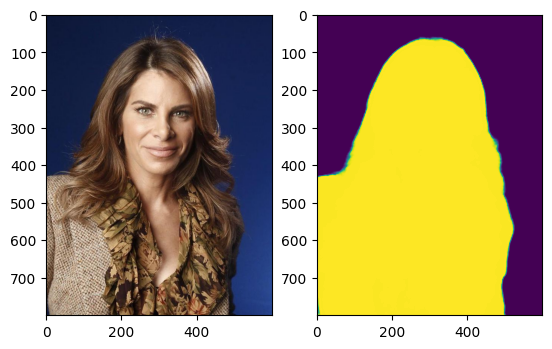

In [8]:
image_paths = sorted(Path("/content/gdrive/MyDrive/dataset/images").iterdir())
mask_paths = sorted(Path("/content/gdrive/MyDrive/dataset/masks").iterdir())

train_portion = 0.9
train_dataset = PhotoDataset(
    images=image_paths[:int(len(image_paths) * train_portion)],
    masks=mask_paths[:int(len(mask_paths) * train_portion)],
)
test_dataset = PhotoDataset(
    images=image_paths[int(len(image_paths) * train_portion):],
    masks=mask_paths[int(len(mask_paths) * train_portion):],
)
print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))

image, mask = train_dataset[0]
print("Image tensor shape:", image.size())
print("Mask tensor shape:", mask.size())
show_image_and_mask(image, mask)

# Переобучение на 4 изображениях

In [9]:
from torch.utils.data import DataLoader, Subset

batch_size = 4

train_loader = DataLoader(
    Subset(train_dataset, range(batch_size)),
    batch_size=batch_size,
)
test_loader = DataLoader(
    Subset(test_dataset, range(batch_size)),
    batch_size=batch_size,
)

In [10]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 15.5 MB/s eta 0:00:00


In [11]:
import torchmetrics
from torch.optim import Optimizer

loss_criterion = nn.BCEWithLogitsLoss()
jaccard = torchmetrics.JaccardIndex(task="binary")

def test(
    model: nn.Module,
    loader: DataLoader) -> tuple[float, float]:
  model.eval()

  loss_sum = 0.0
  jaccard_metric_sum = 0.0
  with torch.no_grad():
      for x, y in tqdm(loader, disable=True):
          outputs = model(x.cuda())
          loss_sum += loss_criterion(outputs, y.cuda()).item()
          jaccard_metric_sum += (jaccard(outputs.cpu(), y.cpu() > jaccard.threshold)).item()

  return (loss_sum / len(loader), jaccard_metric_sum / len(loader))

def train(
    model: nn.Module,
    epochs: int,
    train_loader: DataLoader,
    test_loader: DataLoader,
    optimizer: Optimizer) -> tuple[list, list]:
  train_stats = []
  test_stats = []
  for epoch in range(epochs):
    model.train()
    loss_sum = 0.0
    jaccard_metric_sum = 0.0
    for x, y in tqdm(train_loader, disable=True):
        optimizer.zero_grad()
        outputs = model(x.cuda())

        loss = loss_criterion(outputs, y.cuda())
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        jaccard_metric_sum += (jaccard(outputs.cpu(), y.cpu() > jaccard.threshold)).item()

    train_stat = (loss_sum / len(train_loader), jaccard_metric_sum / len(train_loader))
    test_stat = test(model, test_loader)
    train_stats.append(train_stat)
    test_stats.append(test_stat)
    print("Epoch:", epoch + 1, ", train: ", train_stat, ", test: ", test_stat)
  
  return train_stats, test_stats

In [ ]:
model = UNET(3, 16, 1).cuda()
optimizer = torch.optim.Adam(model.parameters())

train_stats, test_stats = train(
    model, 100, train_loader, test_loader, optimizer
)

Epoch: 1 , train:  (0.7838651537895203, 0.1965918093919754) , test:  (0.6894435882568359, 0.0)
Epoch: 2 , train:  (0.7462419271469116, 0.19260038435459137) , test:  (0.6892273426055908, 0.0)
Epoch: 3 , train:  (0.7187634706497192, 0.20464758574962616) , test:  (0.6890618801116943, 0.0)
Epoch: 4 , train:  (0.7012148499488831, 0.2249397486448288) , test:  (0.6888332366943359, 0.0)
Epoch: 5 , train:  (0.6868536472320557, 0.2457340657711029) , test:  (0.6885576844215393, 0.0)
Epoch: 6 , train:  (0.6732817888259888, 0.25965890288352966) , test:  (0.6882484555244446, 0.0)
Epoch: 7 , train:  (0.6617779731750488, 0.2794499397277832) , test:  (0.6879243850708008, 0.0)
Epoch: 8 , train:  (0.6529980897903442, 0.323030024766922) , test:  (0.6875879764556885, 0.0)
Epoch: 9 , train:  (0.6434715390205383, 0.34311917424201965) , test:  (0.6872529983520508, 0.0)
Epoch: 10 , train:  (0.6343048214912415, 0.37333154678344727) , test:  (0.6869251132011414, 0.0)
Epoch: 11 , train:  (0.6259910464286804, 0.40

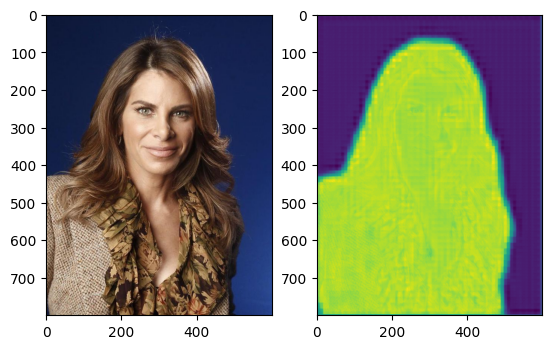

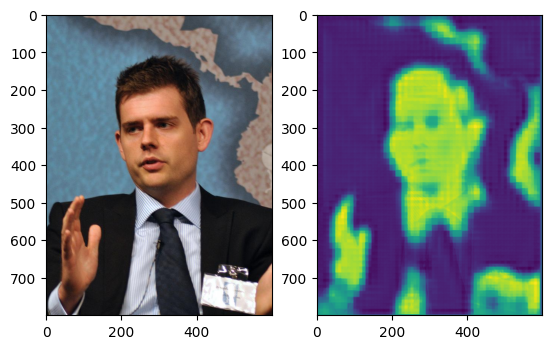

In [ ]:
model.eval()

X, _ = train_dataset[0]
with torch.no_grad():
    pred = model(X.cuda().unsqueeze(0))[0].cpu()
show_image_and_mask(X, nn.functional.sigmoid(pred))

X, _ = test_dataset[1]
with torch.no_grad():
    pred = model(X.cuda().unsqueeze(0))[0].cpu()
show_image_and_mask(X, nn.functional.sigmoid(pred))

In [12]:
def show_stats_train_test_stats(train_stats, test_stats, title=""):
    loss_results, jaccard_results = [], []
    i = 1
    for i, (loss, jaccard) in enumerate(train_stats):
        loss_results.append(
            {
                "Epoch": i,
                "Type": "Train",
                "Value": loss,
            }
        )
        jaccard_results.append(
            {
                "Epoch": i,
                "Type": "Train",
                "Value": jaccard,
            }
        )
    for i, (loss, jaccard) in enumerate(test_stats):
        loss_results.append(
            {
                "Epoch": i,
                "Type": "Test",
                "Value": loss,
            }
        )
        jaccard_results.append(
            {
                "Epoch": i,
                "Type": "Test",
                "Value": jaccard,
            }
        )
    
    lossDf = pd.DataFrame(loss_results)
    jaccardDf = pd.DataFrame(jaccard_results)
    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(15, 7))
    sns.lineplot(lossDf, x="Epoch", y="Value", hue="Type", style="Type", markers=True, dashes=False, ax=axs[0])
    axs[0].set_title("Loss")

    sns.lineplot(jaccardDf, x="Epoch", y="Value", hue="Type", style="Type", markers=True, dashes=False, ax=axs[1])
    axs[1].set_title("Jaccard")

    fig.suptitle(title)
    fig.tight_layout()

In [20]:
def show_stats(stats, title=""):
    loss_results, jaccard_results = [], []
    i = 1
    for i, (loss, jaccard) in enumerate(stats):
        loss_results.append(
            {
                "Epoch": i,
                "Type": "Train",
                "Value": loss,
            }
        )
        jaccard_results.append(
            {
                "Epoch": i,
                "Type": "Train",
                "Value": jaccard,
            }
        )
    
    lossDf = pd.DataFrame(loss_results)
    jaccardDf = pd.DataFrame(jaccard_results)
    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(15, 7))
    sns.lineplot(lossDf, x="Epoch", y="Value", hue="Type", style="Type", markers=True, dashes=False, ax=axs[0])
    axs[0].set_title("Loss")

    sns.lineplot(jaccardDf, x="Epoch", y="Value", hue="Type", style="Type", markers=True, dashes=False, ax=axs[1])
    axs[1].set_title("Jaccard")

    fig.suptitle(title)
    fig.tight_layout()

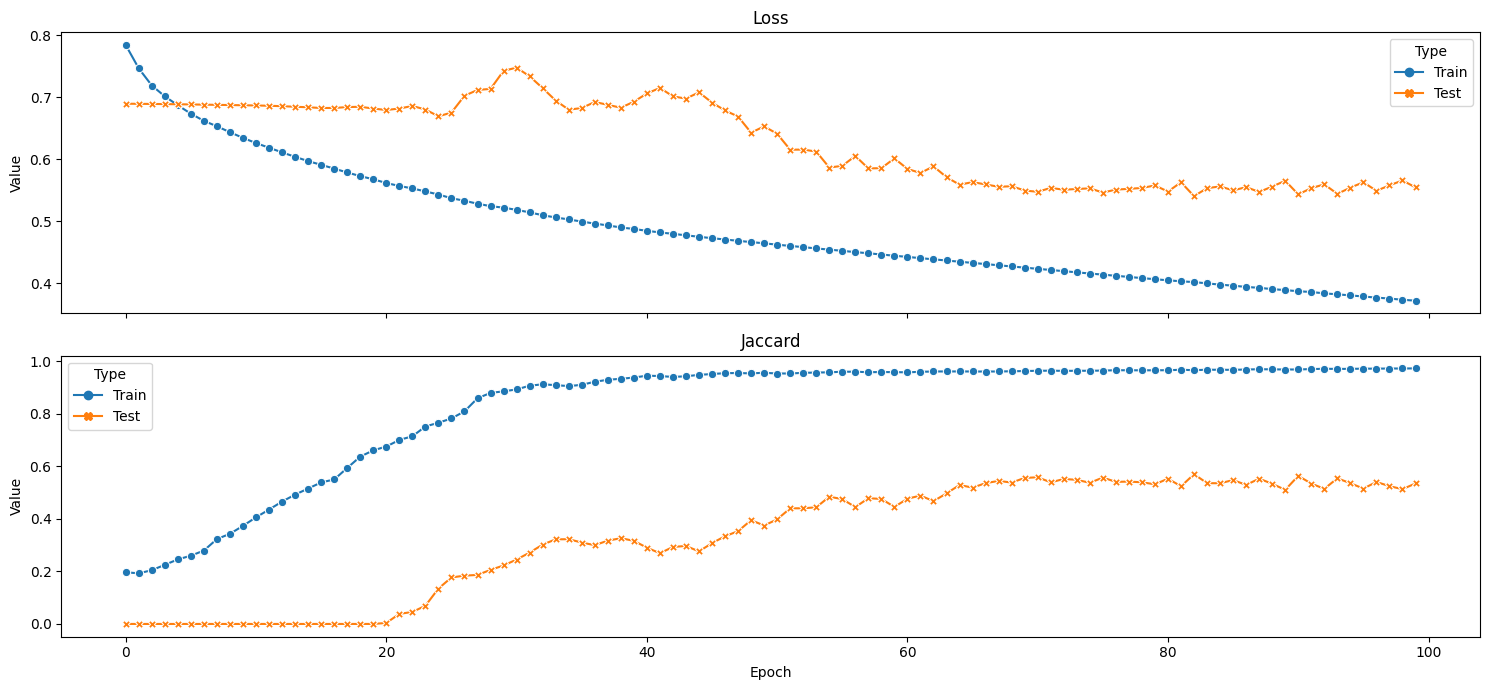

In [ ]:
show_stats_train_test_stats(train_stats, test_stats)

Переобучившись на маленьком наборе данных, модель почти идеально выделяет объект на нем и плохо работает на тестовом наборе данных.

# Обучение на всех тренировочных данных

In [ ]:
batch_size = 20

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
)

model = UNET(3, 16, 1).cuda()
optimizer = torch.optim.Adam(model.parameters())

train_stats, test_stats = train(
    model, 30, train_loader, test_loader, optimizer
)

Epoch: 1 , train:  (0.5986702137523228, 0.5070981863472197) , test:  (0.5527800977230072, 0.49743603765964506)
Epoch: 2 , train:  (0.5045000281598833, 0.6455534670088027) , test:  (0.5003361195325852, 0.6362200856208802)
Epoch: 3 , train:  (0.4512597213188807, 0.6929778277873992) , test:  (0.5002151846885681, 0.5516837954521179)
Epoch: 4 , train:  (0.4177423199017843, 0.7097201738092634) , test:  (0.4193772584199905, 0.692246925830841)
Epoch: 5 , train:  (0.3870304736826155, 0.7256739808453454) , test:  (0.4596873462200165, 0.5993987500667572)
Epoch: 6 , train:  (0.3653872655497657, 0.7388674020767212) , test:  (0.372305816411972, 0.7278324782848358)
Epoch: 7 , train:  (0.35156965918011135, 0.745091669427024) , test:  (0.37089124917984007, 0.7088303446769715)
Epoch: 8 , train:  (0.34034986744324364, 0.751617662774192) , test:  (0.34999547600746156, 0.7236182034015656)
Epoch: 9 , train:  (0.32732517156336044, 0.7615570485591888) , test:  (0.34086231589317323, 0.7345201134681701)
Epoch: 

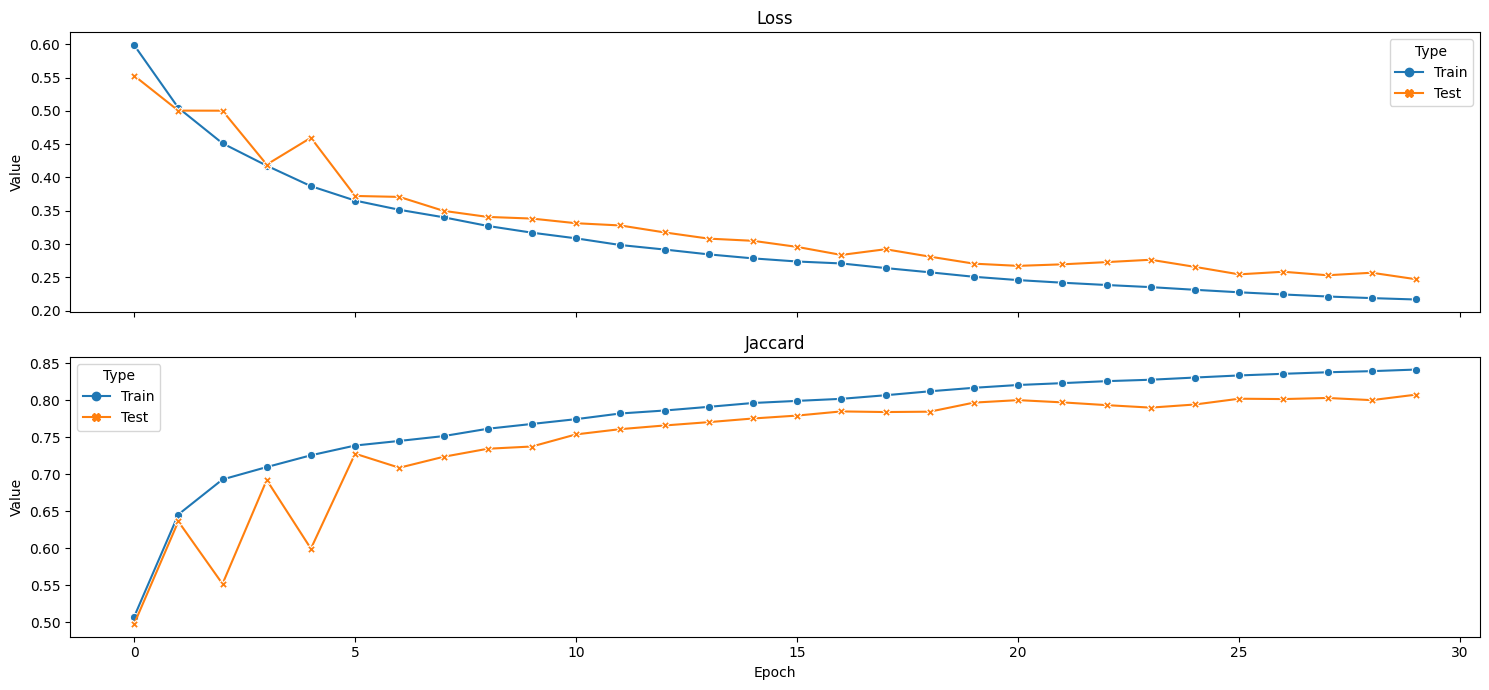

In [ ]:
show_stats_train_test_stats(train_stats, test_stats)

Можно видеть, что начиная с 21 эпохи обучения индекс Жакара достиг своего локального максимума. Скорее всего модель достигла своего наилучшего результата.

In [ ]:
import functools

model.eval()

def worst_test_cases(model: nn.Module, n: int):
    results = []
    with torch.no_grad():
        for x, y in tqdm(test_loader):
            outputs = model(x.cuda())
            jaccard_metric = (jaccard(outputs.cpu(), y.cpu() > jaccard.threshold)).item()
            results.append((outputs[0], jaccard_metric, x))

    return sorted(results, key=functools.cmp_to_key(lambda a, b: a[1] - b[1]))[:n]

worst_cases = worst_test_cases(model, 3)

  0%|          | 0/10 [00:00<?, ?it/s]

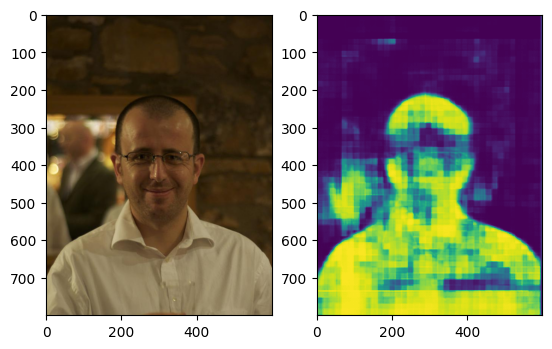

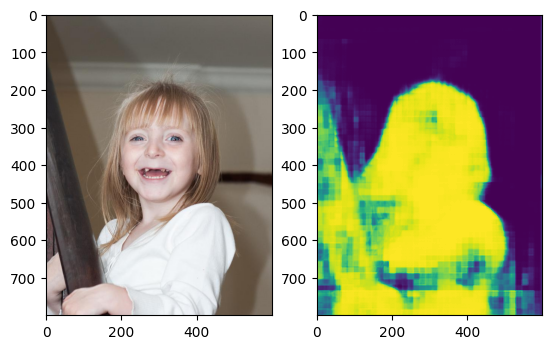

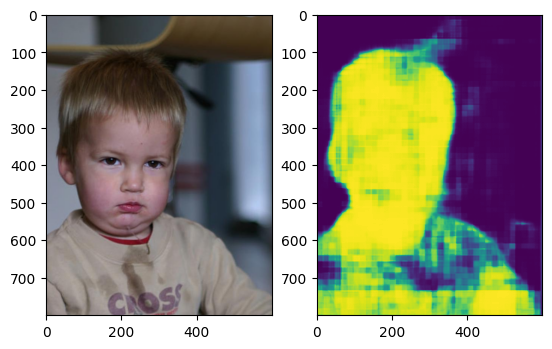

In [ ]:
for p, i, x in worst_cases:
  show_image_and_mask(x[0], nn.functional.sigmoid(p.cpu()))

Видно, что модель не так уж плохо определяет маску для худших случаев.

# Улучшение модели не меняя архитектуру

## Аугментация

Попробуем увеличить количество тренировочных данных при помощи аугментаций. Для каждого тренировочного изображения добавим его копию, отраженную по горизонтали со случайно изменненой яркостью, контрастностью и насыщенностью.

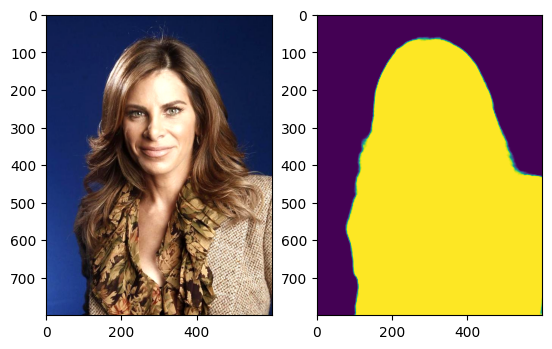

In [13]:
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset, DataLoader

reset_random_seeds()

batch_size = 20

augmentations = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=1),
        transforms.ColorJitter(brightness=0.3, contrast=0.4, saturation=0.4),
    ]
)

train_dataset_augmented = copy.copy(train_dataset)
train_dataset_augmented.transform = augmentations

augmented_image, augmented_mask = train_dataset_augmented[0]
show_image_and_mask(augmented_image, augmented_mask)

train_dataset_extended = ConcatDataset(
    [train_dataset, train_dataset_augmented]
)

train_loader_extended = DataLoader(train_dataset_extended, batch_size=batch_size, shuffle=True)

## Гиперпараметры

В качестве гиперпараметра сети попробуем изменить количество уровней UNET. По умолчанию мы используем 4 уровня, попробуем использовать 3 и 5 уровней.

In [15]:
results = dict()

model = UNET(3, 16, 1, 3).cuda()
optimizer = torch.optim.Adam(model.parameters())

train_stats, test_stats = train(
    model, 20, train_loader_extended, test_loader, optimizer
)
results[3] = (model.cpu(), train_stats, test_stats)
    

Epoch: 1 , train:  (0.5869755228360494, 0.5586968873937924) , test:  (0.332191526889801, 0.7927663326263428)
Epoch: 2 , train:  (0.5217686927980847, 0.6318835126029121) , test:  (0.3750090003013611, 0.7241015434265137)
Epoch: 3 , train:  (0.49967982603443994, 0.6511119678616524) , test:  (0.4004427194595337, 0.7291613817214966)
Epoch: 4 , train:  (0.48452329122357896, 0.6639520015981463) , test:  (0.34848716855049133, 0.759357750415802)
Epoch: 5 , train:  (0.4781675593720542, 0.6688226554128859) , test:  (0.3664570450782776, 0.7407099604606628)
Epoch: 6 , train:  (0.4702360644936562, 0.6771681305434969) , test:  (0.4908228814601898, 0.6566659212112427)
Epoch: 7 , train:  (0.4617590970463223, 0.6857041302654479) , test:  (0.36275964975357056, 0.7184659242630005)
Epoch: 8 , train:  (0.4584143963125017, 0.6860852821005715) , test:  (0.4922277629375458, 0.6935456991195679)
Epoch: 9 , train:  (0.4525813811355167, 0.6941887153519525) , test:  (0.38591712713241577, 0.6997334957122803)
Epoch: 

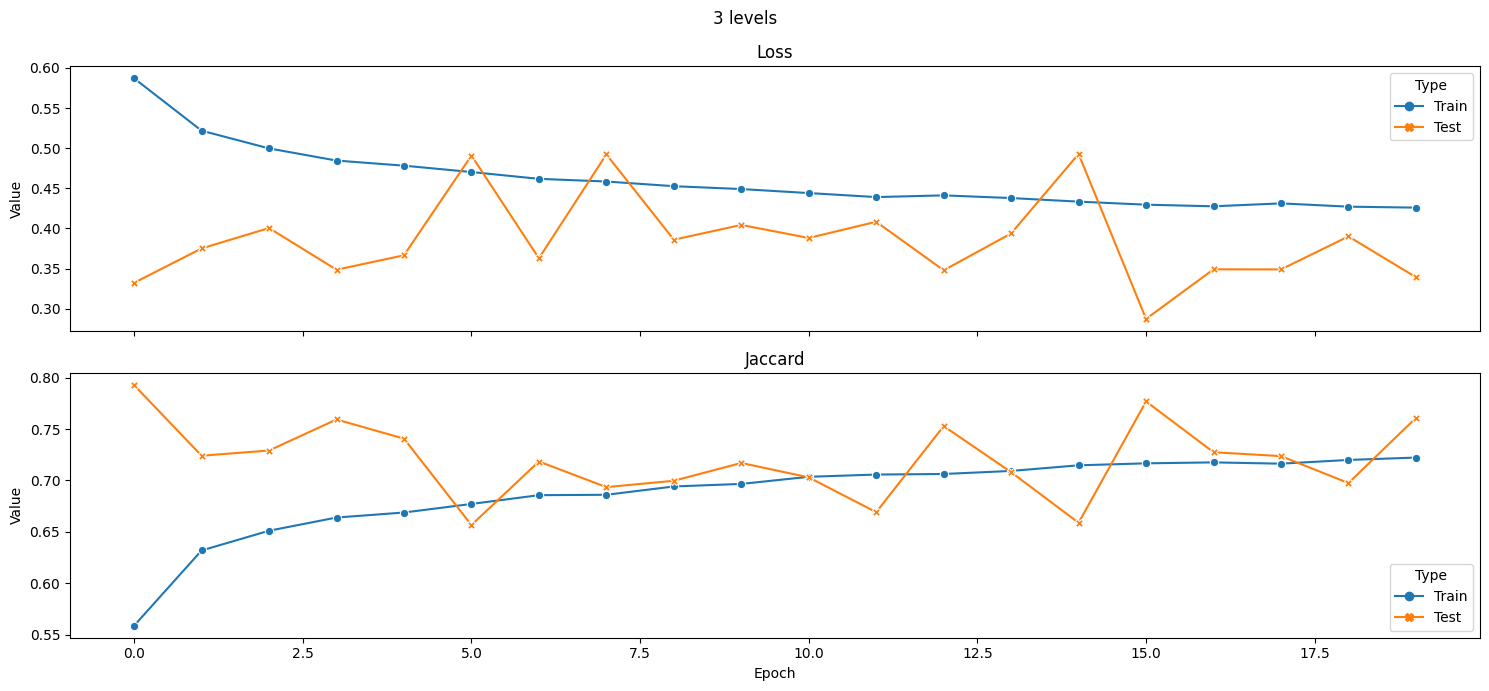

In [16]:
level = 3
_, train_stats, test_stats = results[level]
show_stats_train_test_stats(train_stats, test_stats, title=(str(level) + " levels"))

In [17]:
model = UNET(3, 16, 1, 4).cuda()
optimizer = torch.optim.Adam(model.parameters())

train_stats, test_stats = train(
    model, 20, train_loader_extended, test_loader, optimizer
)
results[4] = (model.cpu(), train_stats, test_stats)

Epoch: 1 , train:  (0.5380144321256214, 0.5725934078296026) , test:  (0.5112993717193604, 0.6335411071777344)
Epoch: 2 , train:  (0.4353042360809114, 0.712331262893147) , test:  (0.3237661123275757, 0.7826184630393982)
Epoch: 3 , train:  (0.40404220339324737, 0.7458953847487767) , test:  (0.3167427182197571, 0.7725253105163574)
Epoch: 4 , train:  (0.3884786319401529, 0.7637634956174426) , test:  (0.3584979176521301, 0.72321617603302)
Epoch: 5 , train:  (0.37230646825499003, 0.7796067009369533) , test:  (0.29934561252593994, 0.7495595216751099)
Epoch: 6 , train:  (0.3622305028968387, 0.7926278034845988) , test:  (0.3358433246612549, 0.7544223070144653)
Epoch: 7 , train:  (0.35466188117861747, 0.7983107831743028) , test:  (0.25089749693870544, 0.8231261372566223)
Epoch: 8 , train:  (0.34575207382440565, 0.8058150268263287) , test:  (0.3655494749546051, 0.7188900113105774)
Epoch: 9 , train:  (0.3408083490199513, 0.8140505270825492) , test:  (0.29625558853149414, 0.7683687806129456)
Epoch:

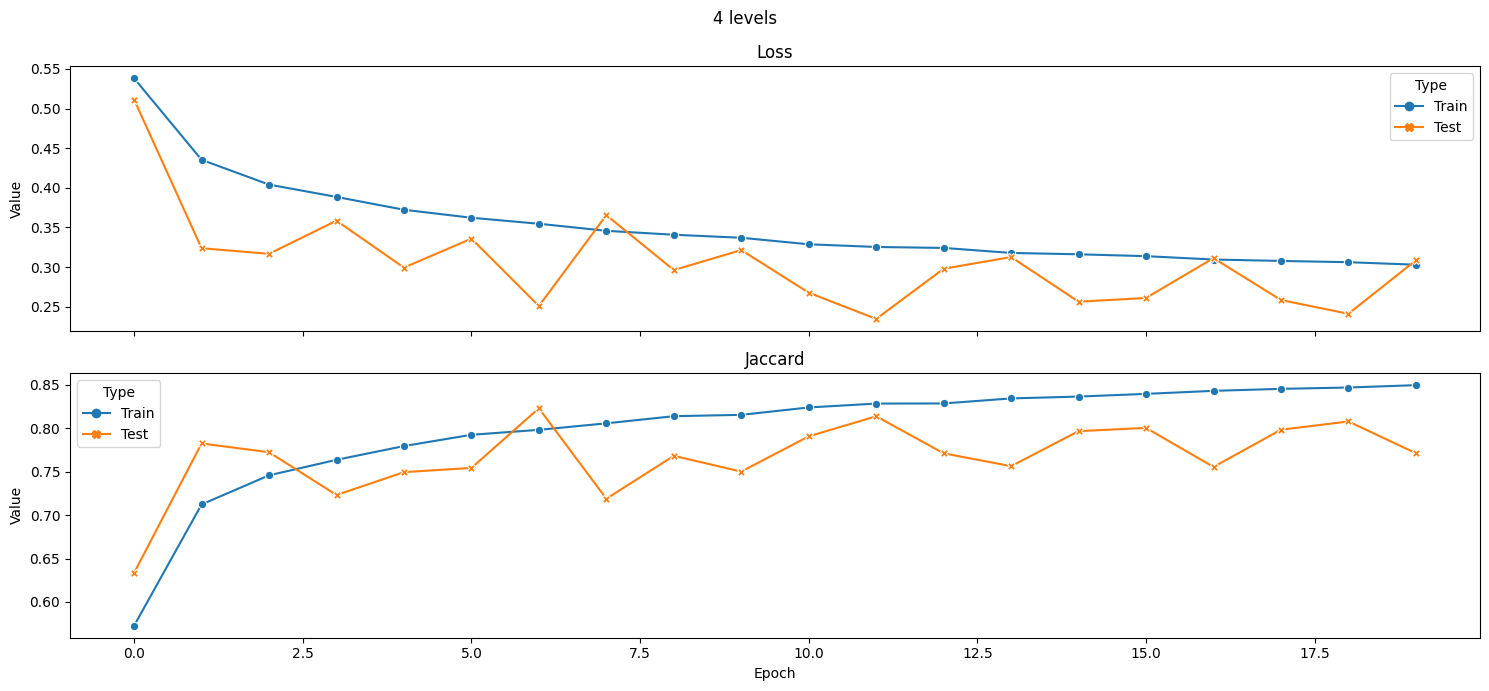

In [18]:
level = 4
_, train_stats, test_stats = results[level]
show_stats_train_test_stats(train_stats, test_stats, title=(str(level) + " levels"))

In [22]:
model = UNET(3, 16, 1, 5).cuda()
optimizer = torch.optim.Adam(model.parameters())

train_stats, test_stats = train(
    model, 20, train_loader_extended, test_loader, optimizer
)
results[5] = (model.cpu(), train_stats, test_stats)

Epoch: 1 , train:  (0.5083649729688963, 0.7059722529517279) , test:  (0.4063977897167206, 0.7522425055503845)
Epoch: 2 , train:  (0.34970606565475465, 0.8377944237656063) , test:  (0.3027926981449127, 0.8040271401405334)
Epoch: 3 , train:  (0.2970057316124439, 0.8682626088460287) , test:  (0.255803644657135, 0.8237465023994446)
Epoch: 4 , train:  (0.26906321288810836, 0.8872155235873328) , test:  (0.26318931579589844, 0.8159239292144775)
Epoch: 5 , train:  (0.2606196677519215, 0.8980760494867961) , test:  (0.22831058502197266, 0.825183629989624)
Epoch: 6 , train:  (0.24856046843859886, 0.9085432549317678) , test:  (0.2204790711402893, 0.8370726704597473)
Epoch: 7 , train:  (0.24374613397651249, 0.9135033908817504) , test:  (0.21148790419101715, 0.8355628848075867)
Epoch: 8 , train:  (0.23657695833179687, 0.9186967614624235) , test:  (0.2092009335756302, 0.8494489789009094)
Epoch: 9 , train:  (0.2281305311454667, 0.9244854231675466) , test:  (0.16453544795513153, 0.8848888874053955)
Epo

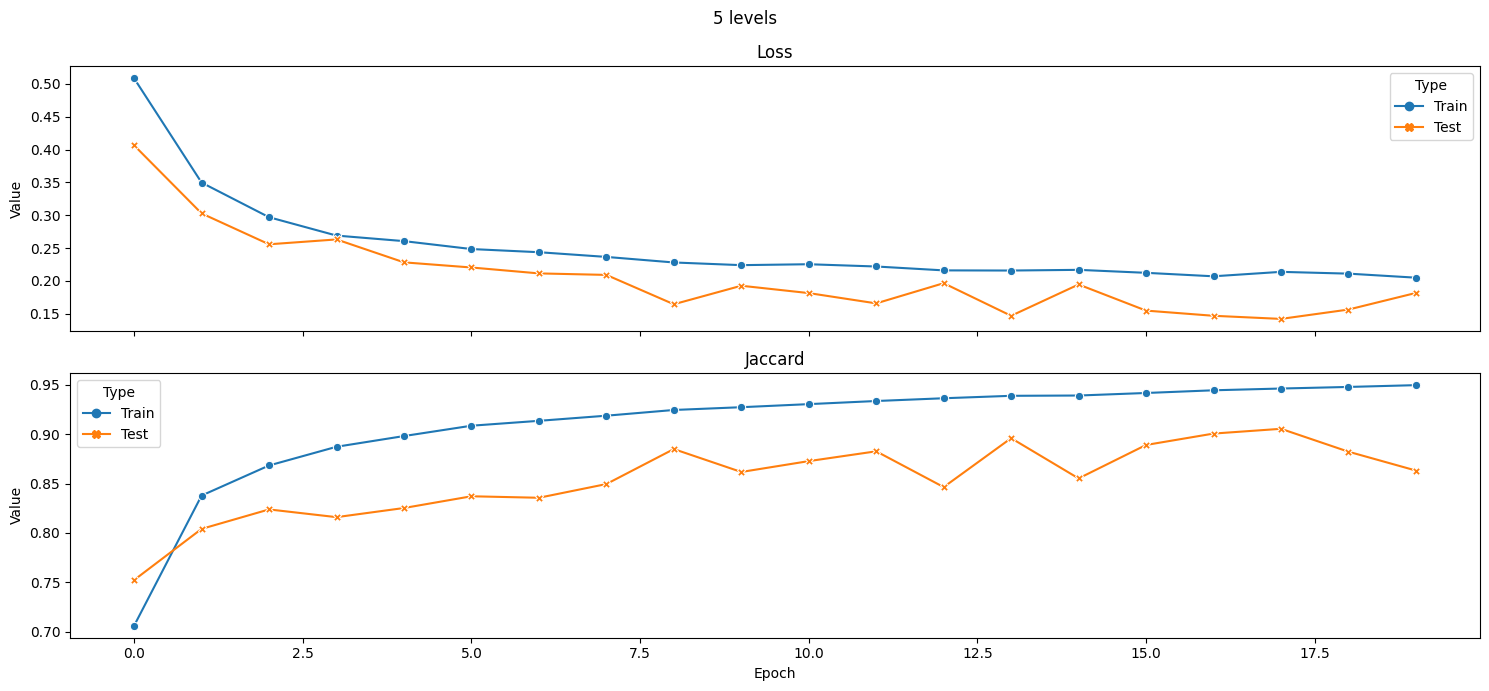

In [23]:
level = 5
_, train_stats, test_stats = results[level]
show_stats_train_test_stats(train_stats, test_stats, title=(str(level) + " levels"))

Чем больше уровней, тем лучше результат: наилучших значений достигает модель с пятью уровнями. Также видно, что аугментация датасета дала небольшой выигрыш. Возможно стоило обучать модель подольше, чтобы получить лучше результаты.

## Test-time аугментация

*   передаем модели тестовое изображение и его же, но отраженное по горизонтали
*   усредняем полученные результаты, предварительно отразив обратно результат, полученный на аугментированном изображении

In [24]:
class UNetHFlipWrapper(nn.Module):
    def __init__(self, in_channels, first_out_channels, exit_channels, n_down=4):
        super().__init__()
        self.unet = UNET(in_channels, first_out_channels, exit_channels, n_down)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.cat([x, functional.hflip(x)])
        x = self.unet(x)

        x, x_alt = torch.chunk(x, 2)
        x_alt = functional.hflip(x_alt)

        stacked = torch.stack([x, x_alt])
        means = torch.mean(stacked, dim=0)

        return means

In [25]:
wrapped_model = UNetHFlipWrapper(3, 16, 1, 5).cuda()
wrapped_model.unet.load_state_dict(model.state_dict())

<All keys matched successfully>

In [26]:
print("loss, jaccard:", test(wrapped_model, test_loader))

loss, jaccard: (0.15650339424610138, 0.8924100399017334)


Test-time аугментация не дала существенных улучшений

# Улучшение модели через изменение архитектуры

Попробуем улучшить качество предсказания модели, увеличив количество сверток на нижнем слое UNET с 2 до 4.

In [40]:
class NConvBlock(nn.Module):
    def __init__(self, n_convs, in_channels, out_channels):
        super().__init__()

        convs = []
        for i in range(n_convs):
            convs += [
                nn.Conv2d(
                    in_channels if i == 0 else out_channels, out_channels, kernel_size=3, padding=1, bias=False
                    ),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
        self.n_conv_block = nn.Sequential(*convs)

    def forward(self, x):
        return self.n_conv_block(x)


class Encoder(nn.Module):
    def __init__(self, in_channels, n_down, n_bottom_convs):
        super().__init__()

        self.enc_layers = nn.ModuleList(
            [ConvBlockDouble(in_channels, in_channels * 2)]
        )
        for i in range(n_down):
            in_channels *= 2
            self.enc_layers.append(
                nn.Sequential(
                    nn.MaxPool2d(2, 2),
                    (
                        ConvBlockDouble(in_channels, in_channels * 2)
                        if i < n_down - 1 else
                        NConvBlock(n_bottom_convs, in_channels, in_channels * 2)
                    ),
                )
            )
    def forward(self, x):
        results = []
        for layer in self.enc_layers:
            x = layer(x)
            results.append(x)
        return results


class UNET(nn.Module):
    def __init__(self, in_channels: int = 3, exit_channels: int = 16, out_channels: int = 1, n_levels: int = 4):
        super().__init__()
        self.encoder = Encoder(in_channels=in_channels, n_down=n_levels, n_bottom_convs=4)
        self.decoder = Decoder(in_channels=in_channels * (2 ** (n_levels + 1)), n_up=n_levels)
        self.out_conv = nn.Conv2d(in_channels=in_channels * 2, out_channels=out_channels, kernel_size=1, padding=0)

    def forward(self, x):
        *residuals, x = self.encoder(x)
        x = self.decoder(x, residuals)
        return self.out_conv(x)


In [41]:
reset_random_seeds()

batch_size = 20

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
)

model = UNET(3, 16, 1).cuda()
optimizer = torch.optim.Adam(model.parameters())

train_stats, test_stats = train(
    model, 20, train_loader, test_loader, optimizer
)

Epoch: 1 , train:  (0.6001530584361818, 0.587555832001898) , test:  (0.4947932541370392, 0.679408460855484)
Epoch: 2 , train:  (0.4548414084646437, 0.7210642794768015) , test:  (0.42498952746391294, 0.7362289130687714)
Epoch: 3 , train:  (0.3655335896544986, 0.7676567223336962) , test:  (0.3484470099210739, 0.7721947014331818)
Epoch: 4 , train:  (0.3129948765039444, 0.7921896252367232) , test:  (0.35136561989784243, 0.7552574455738068)
Epoch: 5 , train:  (0.2803581699728966, 0.8081291092766656) , test:  (0.302017967402935, 0.7889274537563324)
Epoch: 6 , train:  (0.25711176229847804, 0.8212359137005276) , test:  (0.2921935111284256, 0.7918574512004852)
Epoch: 7 , train:  (0.24066830972830455, 0.8306656214925978) , test:  (0.24693667590618135, 0.8209759294986725)
Epoch: 8 , train:  (0.22753658145666122, 0.8393203384346433) , test:  (0.246415913105011, 0.8183264851570129)
Epoch: 9 , train:  (0.21707262479596667, 0.8457626707024044) , test:  (0.2290696457028389, 0.8318931937217713)
Epoch: 

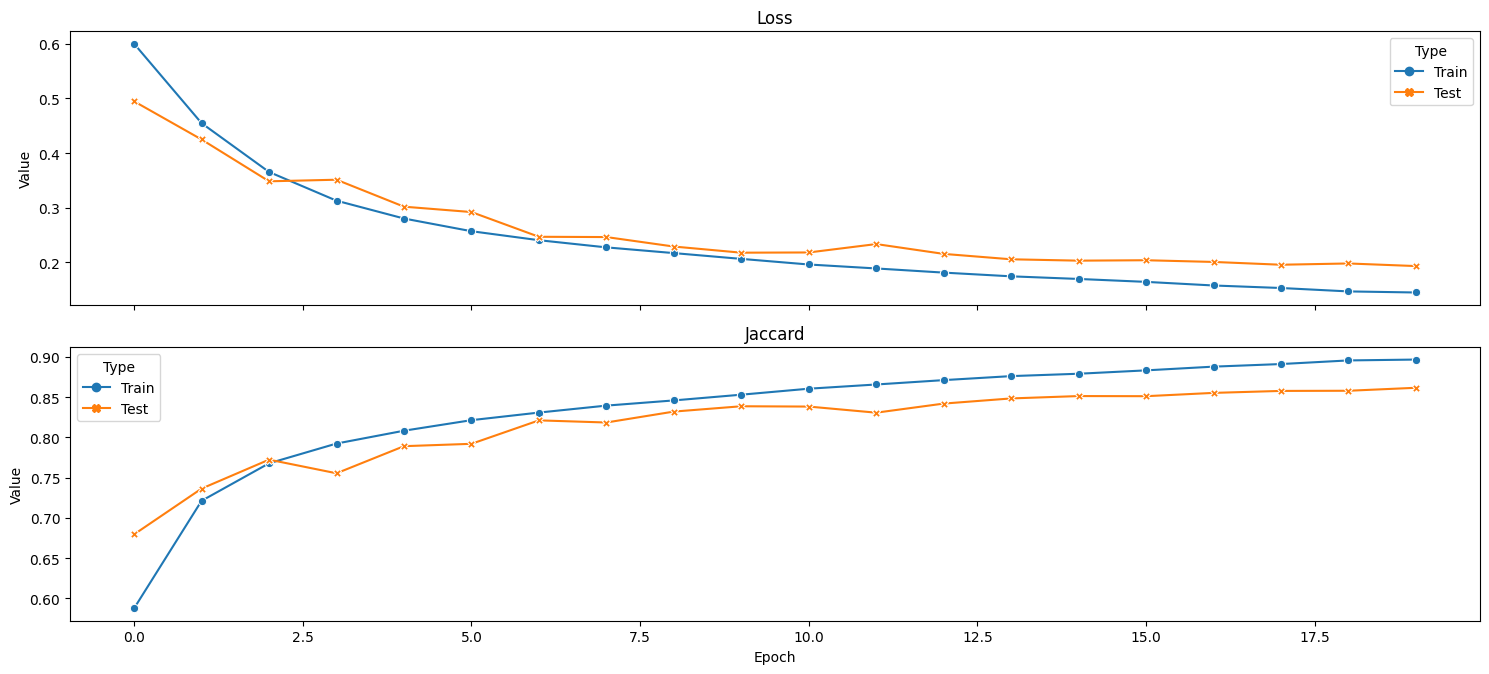

In [42]:
show_stats_train_test_stats(train_stats, test_stats)

Модель с 4 свертками смогла показать довольно хорошие улучшения, индекс Жакара увеличился на 0.06.

# Вывод



*   Стандартная конфигурация Unet показывает хорошую сегметацию на данной задаче.
* Test-time аугментация не дает существенных улучшений
*   Увеличение уровней Unet сильнее всего влияет на качество конечной модели.